In [18]:
%matplotlib inline
%load_ext autoreload

%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [19]:
from utils import Logger

import torch
from torch import nn, optim
from torch.autograd.variable import Variable
from torchvision import transforms, datasets
from tqdm import tqdm_notebook

In [20]:
DATA_FOLDER = './torch_data/VGAN/MNIST'

## Load Data

In [21]:
def mnist_data():
    compose = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize((.5, .5, .5), (.5, .5, .5))
        ])
    out_dir = '{}/dataset'.format(DATA_FOLDER)
    return datasets.MNIST(root=out_dir, train=True, transform=compose, download=True)

In [22]:
# Load data
data = mnist_data()
# Create loader with data, so that we can iterate over it
batch_size = 100
data_loader = torch.utils.data.DataLoader(data, batch_size=batch_size, shuffle=True)
# Num batches
num_batches = len(data_loader)

In [23]:
b, l  = next(iter(data_loader))
b.shape

torch.Size([100, 1, 28, 28])

## Networks

In [24]:
from msgan import GeneratorNet, DiscriminatorNet
discriminator = DiscriminatorNet(hidden_sizes=[256, 128, 64])
generator = GeneratorNet(hidden_sizes=[64, 128, 256], n_input=28*28)
if torch.cuda.is_available():
    discriminator.cuda()
    generator.cuda()

In [25]:
print(f'Cuda Avilable? : {torch.cuda.is_available()}')

Cuda Avilable? : False


## Optimization

In [26]:
# Optimizers
d_optimizer = optim.Adam(discriminator.parameters(), lr=0.0002)
g_optimizer = optim.Adam(generator.parameters(), lr=0.0002)

# Loss function
loss = nn.BCELoss()

# Number of epochs
num_epochs = 200

## Training

In [27]:
from msgan import MSGAN
from itertools import cycle

def noise(size):
    n = Variable(torch.randn(size, generator.n_input))
    if torch.cuda.is_available():
        return n.cuda 
    return n

gan = MSGAN(generator, discriminator, g_optimizer, d_optimizer)

num_epochs = 5
for epoch in tqdm_notebook(range(num_epochs)):
    gan.fit(data_generator=(g[0] for g in data_loader), noise_generator=noise)

4.876319885253906
4.906375885009766
6.321826457977295
6.0164475440979
3.7093071937561035
4.164095878601074
4.325927734375
3.7717390060424805
4.1769700050354
3.906078577041626
6.293524265289307
5.24504280090332
5.188950061798096
7.513908386230469
1.1211278438568115
4.975015163421631


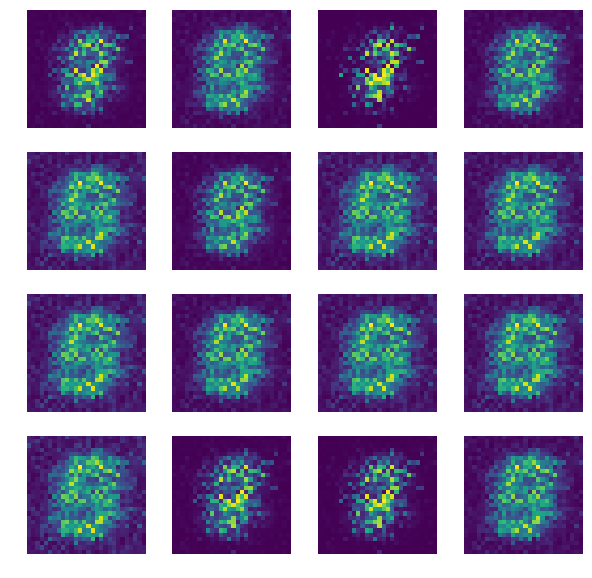

In [28]:
import numpy as np
import matplotlib.pyplot as plt


test_image = generator(noise(16))
images = np.array(test_image.data).reshape(16, 28, 28)

fig, axs = plt.subplots(4, 4, figsize=(10, 10))

for img, ax in zip(images, axs.ravel()):
    ax.imshow(img)
    ax.axis('off')
    d = discriminator(torch.Tensor(img.ravel()))
    print(float(loss(d, torch.ones(1))))

9.179156222671736e-06
6.19907514192164e-05
0.16490361094474792
1.1920829479095119e-07
1.1920829479095119e-07
0.008548814803361893
-1.000088900582341e-12
1.4782060134166386e-05
9.298366421717219e-06
-1.000088900582341e-12
0.014753155410289764
1.299389623454772e-05
-1.000088900582341e-12
-1.000088900582341e-12
7.271792128449306e-06
1.299389623454772e-05


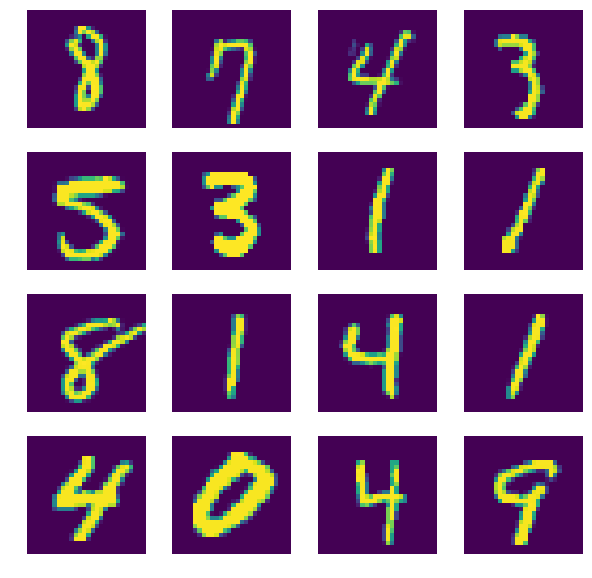

In [29]:
fig, axs = plt.subplots(4, 4, figsize=(10, 10))

batch, _ = next(iter(data_loader))
for img, ax in zip(batch, axs.ravel()):
    ax.imshow(img[0, :, :, ])
    ax.axis('off')
    img = img.view(28*28)
    d = discriminator(torch.Tensor(img))
    l = loss(d, torch.ones(1))
    print(float(l))